In [18]:
%matplotlib inline


# Gaussian mixture PHD tutorial


## Background

Previous tutorials have described the difficulties of state estimation when there are
multiple targets under consideration. The probability hypothesis density (PHD) filter has been proposed as a solution
to this problem that is analogous to the Kalman Filter's solution in single-object
tracking. Where the Kalman filter propagates the first order movement of the posterior
distribution of the target, the PHD filter creates a multiple target posterior
distribution and propagates its first-order statistical moment, or PHD. At each
time instance, the collections of targets and detections (including both measurements
and false detections) are modelled as random finite sets. This means that the number
of elements in each set is a random variable, and the elements themselves follow a
probability distribution. Note that this is different from previously discussed filters
which have a constant or known number of objects.

In a GM-PHD filter, each object is assumed to follow a linear Gaussian model, just like
we saw in previous tutorials. However, the multiple objects need not have the same
covariance matrices, meaning that the multiple target posterior distribution will be
a **Gaussian mixture (GM)**.



First we will recall some of the formulas that will be used in this filter.

Transition Density: Given a state $p(\mathbf{x}_{k-1})$ at time $k-1$, the probability density of
a transition to the state $p(\mathbf{x}_k)$ at time $k$ is given by
$f_{k\vert k-1}(\mathbf{x}_{k}\vert \mathbf{x}_{k-1})$

Likelihood Function: Given a state $\mathbf{x}_{k}$ at time $k$, the probability density of
receiving the detection $\mathbf{z}_{k}$ is given by
$g_{k}(\mathbf{z}_{k}\vert \mathbf{x}_{k})$

The Posterior Density: The probability density of state $\mathbf{x}_{k}$ given all the previous
observations is denoted by $p_{k}(\mathbf{x}_{k}\vert \mathbf{z}_{1:k})$. Using an initial density
$p_{0}(\cdot)$, we can apply Bayes' recursion to show that the posterior density is actually

\begin{align}p_{k}(\mathbf{x}_{k}\vert \mathbf{z}_{1:k}) = {{g_{k}(\mathbf{z}_{k}\vert \mathbf{x}_{k})p_{k\vert k-1}(\mathbf{x}_{k}\vert \mathbf{z}_{1:k-1})} \over {\int g_{k}(\mathbf{z}_{k}\vert \mathbf{x})p_{k\vert k-1}(\mathbf{x}\vert \mathbf{z}_{1:k-1})d\mathbf{x}}}\end{align}


It is important to notice here that the state at time $k$ can be derived wholly by
the state at time $k-1$.

Here we also introduce the following notation:
$p_{S,k}(\zeta)$ is the probability that a target $S$ will exist at time $k$ given that
its previous state was $\zeta$

Suppose we have the random finite set $\mathbf{X}_{k} \in \chi$ corresponding to the set of
target states at time $k$ and $\mathbf{X}_k$ has probability distribution $P$. Integrating over
every region $S \in \chi$, we get a formula for the first order moment (also called the
intensity) at time $k$, $v_{k}$

\begin{align}\int \left \vert \mathbf{X}_{k}\cap S\right \vert P(d\mathbf{X}_k)=\int _{S}v_{k}(x)dx.\end{align}

The set of targets spawned at time $k$ by a target whose previous state was $\zeta$ is the
random finite set $\mathbf{B}_{k|k-1}$. This new set of targets has intensity denoted $\beta_{k|k-1}$.

The intensity of the random finite set of births at time $k$ is given by $\gamma_{k}$.

The intensity of the random finite set of clutter at time $k$ is given by $\kappa_{k}$.

The probability that a state $x$ will be detected at time $k$  is given by $p_{D, k}(x)$.



### Assumptions
The GM-PHD filter assumes that each target is independent of one another in both generated
observations and in evolution. Clutter is also assumed to be independent of the target
measurements. Finally, we assume that the target locations at a given time step are
dependent on the multi-target prior density, and their distributions are Poisson. Typically,
the target locations are also dependent on previous measurements, but that has been omitted
in current GM-PHD algorithms.

### Posterior Propagation Formula
Under the above assumptions, Vo and Ma [#]_ proved that the posterior intensity can be
propagated in time using the PHD recursion as follows:
$\eqalignno{v _{ k\vert k-1} (x) =&\, \int p_{S,k}(\zeta)f_{k\vert k-1} (x\vert \zeta)v_{k-1}(\zeta)d\zeta\cr & +\int \beta_{k\vert k-1} (x\vert \zeta)v_{k-1}(\zeta)d\zeta+\gamma _{k}(x) & \cr v_{k} (x) =&\, \left[ 1-p_{D,k}(x)\right]v_{k\vert k-1}(x)\cr & +\!\!\sum\limits _{z\in Z_{k}} \!{{ p_{D,k}(x)g_{k}(z\vert x)}v_{k\vert k-1}(x) \over { \kappa _{k}(z)\!+\!\int p_{D,k}(\xi)g_{k}(z\vert \xi)v_{k\vert k-1}(\xi)}} . \cr &&}$

For more information about the specific formulas for linear and non-linear Gaussian models,
please see Vo and Ma's full paper.



## A Ground-Based Multi-Target Simulation
This simulation will include several targets moving in different directions across the 2D
Cartesian plane. The start locations of each object are random. These start locations are
called priors and are known to the filter, via the density $p_{0}(\cdot)$ discussed above.

At each time step, new targets are created and some targets die according to defined
probabilities.




We start with some imports as usual.



In [19]:
# Imports for plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn-colorblind')
# Other general imports
import numpy as np
from ordered_set import OrderedSet
from datetime import datetime, timedelta
start_time = datetime.now()

C:\Users\danru\AppData\Local\Temp\ipykernel_16852\1104603530.py:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



### Generate ground truth

At the end of the tutorial we will plot the Gaussian mixtures. The ground truth Gaussian
mixtures are stored in this list where each index refers to an instance in time and holds
all ground truths at that time step.



In [20]:
truths_by_time = []

# Create transition model
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(0.3), ConstantVelocity(0.3)))

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
start_time = datetime.now()
truths = OrderedSet()  # Truths across all time
current_truths = set()  # Truths alive at current time
start_truths = set()
number_steps = 20
death_probability = 0.005
birth_probability = 0.2

# Initialize 3 truths. This can be changed to any number of truths you wish.
truths_by_time.append([])
for i in range(3):
    x, y = initial_position = np.random.uniform(-30, 30, 2)  # Range [-30, 30] for x and y
    x_vel, y_vel = (np.random.rand(2))*2 - 1  # Range [-1, 1] for x and y velocity
    state = GroundTruthState([x, x_vel, y, y_vel], timestamp=start_time)

    truth = GroundTruthPath([state])
    current_truths.add(truth)
    truths.add(truth)
    start_truths.add(truth)
    truths_by_time[0].append(state)

# Simulate the ground truth over time
for k in range(number_steps):
    truths_by_time.append([])
    # Death
    for truth in current_truths.copy():
        if np.random.rand() <= death_probability:
            current_truths.remove(truth)
    # Update truths
    for truth in current_truths:
        updated_state = GroundTruthState(
            transition_model.function(truth[-1], noise=True, time_interval=timedelta(seconds=1)),
            timestamp=start_time + timedelta(seconds=k))
        truth.append(updated_state)
        truths_by_time[k].append(updated_state)
    # Birth
    for _ in range(np.random.poisson(birth_probability)):
        x, y = initial_position = np.random.rand(2) * [120, 120]  # Range [0, 20] for x and y
        x_vel, y_vel = (np.random.rand(2))*2 - 1  # Range [-1, 1] for x and y velocity
        state = GroundTruthState([x, x_vel, y, y_vel], timestamp=start_time + timedelta(seconds=k))

        # Add to truth set for current and for all timestamps
        truth = GroundTruthPath([state])
        current_truths.add(truth)
        truths.add(truth)
        truths_by_time[k].append(state)

Plot the ground truth




In [21]:
from stonesoup.plotter import Plotterly
plotter = Plotterly()
plotter.plot_ground_truths(truths, [0, 2])
plotter.fig

### Generate detections with clutter
Next, generate detections with clutter just as in the previous tutorial. The clutter is
assumed to be uniformly distributed across the entire field of view, here assumed to
be the space where $x \in [-200, 200]$ and $y \in [-200, 200]$.



In [22]:
# Make the measurement model
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )


# Generate detections and clutter

from scipy.stats import uniform

from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter

all_measurements = []
# The probability detection and clutter rate play key roles in the posterior intensity.
# They can be changed to see their effect.
probability_detection = 0.9
clutter_rate = 3.0

for k in range(number_steps):
    measurement_set = set()
    timestamp = start_time + timedelta(seconds=k)

    for truth in truths:
        try:
            truth_state = truth[timestamp]
        except IndexError:
            # This truth not alive at this time. Skip this iteration of the for loop.
            continue

        # Generate actual detection from the state with a 10% chance that no detection is received.
        if np.random.rand() <= probability_detection:
            # Generate actual detection from the state
            measurement = measurement_model.function(truth_state, noise=True)
            measurement_set.add(TrueDetection(state_vector=measurement,
                                              groundtruth_path=truth,
                                              timestamp=truth_state.timestamp,
                                              measurement_model=measurement_model))

    # Generate clutter at this time-step
    for _ in range(np.random.poisson(clutter_rate)):
        x = uniform.rvs(-200, 400)
        y = uniform.rvs(-200, 400)
        measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=timestamp,
                                    measurement_model=measurement_model))

    all_measurements.append(measurement_set)



# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2])
plotter.fig

### Create the Predictor and Updater

The updater is a :class:`~.PHDUpdater`, and since it uses the mixed Gaussian paths, it is a
GM-PHD updater. For each individual track we use a :class:`~.KalmanUpdater`. Here we assume
that the measurement range and clutter spatial density are known to the filter. We
invite you to change these variables to mimic removing this assumption.



In [23]:
from stonesoup.updater.kalman import KalmanUpdater
kalman_updater = KalmanUpdater(measurement_model)

# Area in which we look for target. Note that if a target appears outside of this area the
# filter will not pick up on it.
meas_range = np.array([[-1, 1], [-1, 1]])*200
clutter_spatial_density = clutter_rate/np.prod(np.diff(meas_range))

from stonesoup.updater.pointprocess import PHDUpdater
updater = PHDUpdater(
    kalman_updater,
    clutter_spatial_density=clutter_spatial_density,
    prob_detection=probability_detection,
    prob_survival=1-death_probability)

The GM-PHD filter quantifies the predicted-measurement distance, just as in previous
tutorials. The metric for this is the Mahalanobis distance. We also require two
objects which together form the predictor and to generate hypotheses (or predictions)
based on the previous state. Recall that the GM-PHD propagates the first-order
statistical moment which is a Gaussian mixture. The predicted state at the next time
step is also a Gaussian mixture and can be determined solely by the propagated prior.
Determining this predicted Gaussian mixture is the job for the
:class:`~.GaussianMixtureHypothesiser` class. We must also generate a prediction for each track
in the simulation, and so use the :class:`~.DistanceHypothesiser` object as before.



In [24]:
from stonesoup.predictor.kalman import KalmanPredictor
kalman_predictor = KalmanPredictor(transition_model)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
base_hypothesiser = DistanceHypothesiser(kalman_predictor, kalman_updater, Mahalanobis(), missed_distance=3)

from stonesoup.hypothesiser.gaussianmixture import GaussianMixtureHypothesiser
hypothesiser = GaussianMixtureHypothesiser(base_hypothesiser, order_by_detection=True)

The updater takes a list of hypotheses from the hypothesiser and transforms them into
potential new states for our tracks. Each state is a :class:`~.TaggedWeightedGaussianState`
object and has a state vector, covariance, weight, tag, and timestamp. Some of the
updated states have a very low weight, indicating that they do not contribute much to
the Gaussian mixture. To ease the computational complexity, a :class:`~.GaussianMixtureReducer`
is used to merge and prune many of the states based on provided thresholds. States whose
distance is less than the merging threshold will be combined, and states whose weight
is less than the pruning threshold will be removed. Additionally, the
:class:`~.GaussianMixtureReducer` has an optional parameter for the maximum number of
components that will be kept in the mixture, `max_number_components`. The reducer will keep
only the `max_number_components` components with the highest weights. This threshold can be
used when the approximate number of targets is known, or when there is high uncertainty and it
is hard to decide on a pruning threshold. It will not be used in this example.



In [25]:
from stonesoup.mixturereducer.gaussianmixture import GaussianMixtureReducer
# Initialise a Gaussian Mixture reducer
merge_threshold = 5     # Threshold Squared Mahalanobis distance
prune_threshold = 1E-8  # Threshold component weight

reducer = GaussianMixtureReducer(
    prune_threshold=prune_threshold,
    pruning=True,
    merge_threshold=merge_threshold,
    merging=True)

Now we initialize the Gaussian mixture at time k=0. In this implementation, the GM-PHD
tracker knows the start state of the first 3 tracks that were created. After that it
must pick up on new tracks and discard old ones. It is not necessary to provide the
tracker with these start states, you can simply define the `tracks` as an empty set.

Feel free to change the `state_vector` from the actual truth state vector to something
else. This would mimic if the tracker was unsure about where the objects were originating.



In [26]:
from stonesoup.types.state import TaggedWeightedGaussianState
from stonesoup.types.track import Track
from stonesoup.types.array import CovarianceMatrix
covar = CovarianceMatrix(np.diag([10, 5, 10, 5]))

tracks = set()
for truth in start_truths:
    new_track = TaggedWeightedGaussianState(
            state_vector=truth.state_vector,
            covar=covar**2,
            weight=0.25,
            tag=TaggedWeightedGaussianState.BIRTH,
            timestamp=start_time)
    tracks.add(Track(new_track))

The hypothesiser takes the current Gaussian mixture as a parameter. Here we will
initialize it to use later.



In [27]:
reduced_states = set([track[-1] for track in tracks])

To ensure that new targets get represented in the filter, we must add a birth
component to the Gaussian mixture at every time step. The birth component's mean and
covariance must create a distribution that covers the entire state space, and its weight
must be equal to the expected number of births per timestep. For more information about
the birth component, see the algorithm provided in [#]_. If the state space is very
large, it becomes inefficient to hold a component that covers it. Alternative
implementations (as well as more discussion about the birth component) are discussed in
[#]_.



In [28]:
birth_covar = CovarianceMatrix(np.diag([1000, 2, 1000, 2]))
birth_component = TaggedWeightedGaussianState(
    state_vector=[0, 0, 0, 0],
    covar=birth_covar**2,
    weight=0.25,
    tag='birth',
    timestamp=start_time
)

### Run the Tracker
Now that we have all of our components, we can create a tracker. At each time instance,
the tracker will go through four steps: hypothesise, update, reduce, and match. Let us
briefly recap these four steps. The 'hypothesise' step is similar to the 'prediction'
step in other filters. It uses the existing state space and the measurements to generate
a list of all hypotheses for this time step (remember, each hypothesis is a Gaussian
component). In the 'update' step, the filter combines the hypotheses into an updated
Gaussian mixture. The 'reduce' step helps limit the computational complexity by merging
and pruning the updated Gaussian mixture. The filter returns this final set of states
and then we perform a 'match' step where we use the states' tags to match them with an
existing track (or create a new track).



These lists will be used to plot the Gaussian mixtures later. They are not used in
the filter itself.



In [29]:
all_gaussians = []
tracks_by_time = []

We need a threshold to compare state weights against. If the state has a high enough
weight in the Gaussian mixture, we will add it to an existing track or make a new
track for it. Lowering this value makes the filter more sensitive but may also
increase the number of false estimations. Increasing this value may increase the number
of missed targets.



In [30]:
state_threshold = 0.25

for n, measurements in enumerate(all_measurements):
    tracks_by_time.append([])
    all_gaussians.append([])

    # The hypothesiser takes in the current state of the Gaussian mixture. This is equal to the list of
    # reduced states from the previous iteration. If this is the first iteration, then we use the priors
    # defined above.
    current_state = reduced_states

    # At every time step we must add the birth component to the current state
    if measurements:
        time = list(measurements)[0].timestamp
    else:
        time = start_time + timedelta(seconds=n)
    birth_component.timestamp = time
    current_state.add(birth_component)

    # Generate the set of hypotheses
    hypotheses = hypothesiser.hypothesise(current_state,
                                          measurements,
                                          timestamp=time,
                                          # keep our hypotheses ordered by detection, not by track
                                          order_by_detection=True)

    # Turn the hypotheses into a GaussianMixture object holding a list of states
    updated_states = updater.update(hypotheses)

    # Prune and merge the updated states into a list of reduced states
    reduced_states = set(reducer.reduce(updated_states))

    # Add the reduced states to the track list. Each reduced state has a unique tag. If this tag matches the tag of a
    # state from a live track, we add the state to that track. Otherwise, we generate a new track if the reduced
    # state's weight is high enough (i.e. we are sufficiently certain that it is a new track).
    for reduced_state in reduced_states:
        # Add the reduced state to the list of Gaussians that we will plot later. Have a low threshold to eliminate some
        # clutter that would make the graph busy and hard to understand
        if reduced_state.weight > 0.05: all_gaussians[n].append(reduced_state)

        tag = reduced_state.tag
        # Here we check to see if the state has a sufficiently high weight to consider being added.
        if reduced_state.weight > state_threshold:
            # Check if the reduced state belongs to a live track
            for track in tracks:
                track_tags = [state.tag for state in track.states]

                if tag in track_tags:
                    track.append(reduced_state)
                    tracks_by_time[n].append(reduced_state)
                    break
            else:  # Execute if no "break" is hit; i.e. no track with matching tag
                # Make a new track out of the reduced state
                new_track = Track(reduced_state)
                tracks.add(new_track)
                tracks_by_time[n].append(reduced_state)

### Plot the Tracks
First, determine the x and y range for axes. We want to zoom in as much as possible
on the measurements and tracks while not losing any of the information. This section
is not strictly necessary as we already set the field of view to be the range [-100, 100]
for both x and y. However, sometimes an object may leave the field of view. If you want
to ignore objects that have left the field of view, comment out this section and define
the variables
`x_min` = `y_min` = -100 and `x_max` = `y_max` = 100.



In [31]:
x_min, x_max, y_min, y_max = 0, 0, 0, 0

# Get bounds from the tracks
for track in tracks:
    for state in track:
        x_min = min([state.state_vector[0], x_min])
        x_max = max([state.state_vector[0], x_max])
        y_min = min([state.state_vector[2], y_min])
        y_max = max([state.state_vector[2], y_max])

# Get bounds from measurements
for measurement_set in all_measurements:
    for measurement in measurement_set:
        if type(measurement) == TrueDetection:
            x_min = min([measurement.state_vector[0], x_min])
            x_max = max([measurement.state_vector[0], x_max])
            y_min = min([measurement.state_vector[1], y_min])
            y_max = max([measurement.state_vector[1], y_max])

Now we can use the :class:`~.Plotter` class to draw the tracks. Note that if the birth
component it plotted you will see its uncertainty ellipse centred around $(0, 0)$.
This ellipse need not cover the entire state space, as long as the distribution does.



In [32]:
# Plot the tracks
plotter = Plotterly()
plotter.plot_ground_truths(truths, [0, 2])
plotter.plot_measurements(all_measurements, [0, 2])
plotter.plot_tracks(tracks, [0, 2], uncertainty=True)
plotter.fig.update_xaxes(range=[x_min-5, x_max+5])
plotter.fig.update_yaxes(range=[y_min-5, y_max+5])
plotter.fig

### Examining the Gaussian Mixtures
At every time step, the above GM-PHD algorithm creates a Gaussian mixture, which is
a distribution over our target space. The following sections take a closer look at what
this Gaussian really looks like. Note that the figures below only include the reduced
states which have weight greater than 0.05. This decreases the overall number of states
shown in the mixture and makes it easier to examine. But you can change this threshold
parameter in the Run The Tracker section.

First we define a function that will help generate the z values for the Gaussian
mixture. This lets us plot it later. This function has been updated from the one
found [here](https://notebook.community/empet/Plotly-plots/Gaussian-Mixture) from
[this](https://github.com/empet/Plotly-plotse) GPL-3.0 licensed repository.




In [33]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def get_mixture_density(x, y, weights, means, sigmas):
    # We use the quantiles as a parameter in the multivariate_normal function. We don't need to pass in any quantiles,
    # but the last axis must have the components x and y
    quantiles = np.empty(x.shape + (2,))  # if  x.shape is (m,n) then quantiles.shape is (m,n,2)
    quantiles[:, :, 0] = x
    quantiles[:, :, 1] = y

    # Go through each gaussian in the list and add its PDF to the mixture
    z = np.zeros(x.shape)
    for gaussian in range(len(weights)):
        z += weights[gaussian]*multivariate_normal.pdf(x=quantiles, mean=means[gaussian, :], cov=sigmas[gaussian])
    return z

For each timestep, create a new figure with 2 subplots. The plot on the left will
show the 3D Gaussian Mixture density. The plot on the right will show a 2D
birds-eye-view of the space, including the ground truths, detections, clutter, and tracks.



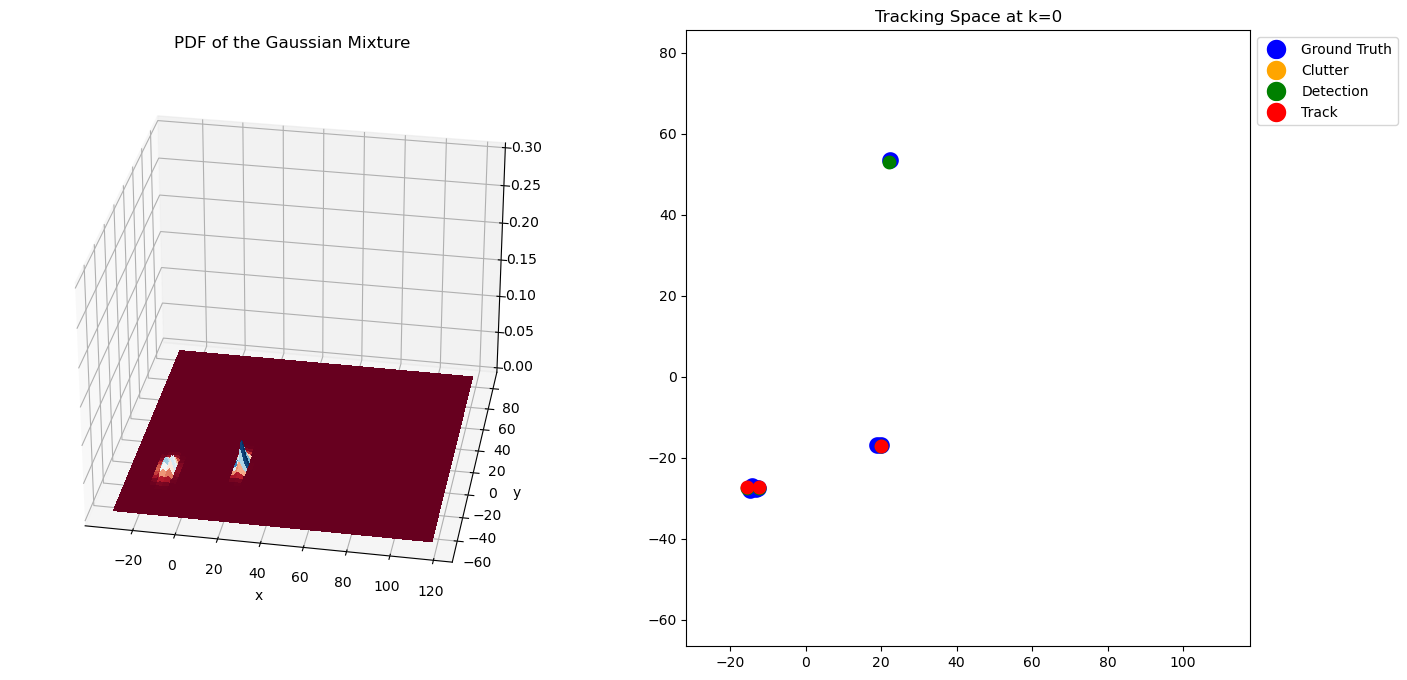

In [34]:
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D  # Will be used when making the legend

# This is the function that updates the figure we will be animating. As parameters we must
# pass in the elements that will be changed, as well as the index i
def animate(i, sf, truths, tracks, measurements, clutter):
    # Set up the axes
    axL.clear()
    axR.set_title('Tracking Space at k='+str(i))
    axL.set_xlabel("x")
    axL.set_ylabel("y")
    axL.set_title('PDF of the Gaussian Mixture')
    axL.view_init(elev=30, azim=-80)
    axL.set_zlim(0, 0.3)

    # Initialize the variables
    weights = []  # weights of each Gaussian. This is analogous to the probability of its existence
    means = []    # means of each Gaussian. This is equal to the x and y of its state vector
    sigmas = []   # standard deviation of each Gaussian.

    # Fill the lists of weights, means, and standard deviations
    for state in all_gaussians[i]:
        weights.append(state.weight)
        means.append([state.state_vector[0], state.state_vector[2]])
        sigmas.append([state.covar[0][0], state.covar[1][1]])
    means = np.array(means)
    sigmas = np.array(sigmas)

    # Generate the z values over the space and plot on the left axis
    zarray[:, :, i] = get_mixture_density(x, y, weights, means, sigmas)
    sf = axL.plot_surface(x, y, zarray[:, :, i], cmap=cm.RdBu, linewidth=0, antialiased=False)

    # Make lists to hold the new ground truths, tracks, detections, and clutter
    new_truths, new_tracks, new_measurements, new_clutter = [], [], [], []
    for truth in truths_by_time[i]:
        new_truths.append([truth.state_vector[0], truth.state_vector[2]])
    for state in tracks_by_time[i]:
        new_tracks.append([state.state_vector[0], state.state_vector[2]])
    for measurement in all_measurements[i]:
        if isinstance(measurement, TrueDetection):
            new_measurements.append([measurement.state_vector[0], measurement.state_vector[1]])
        elif isinstance(measurement, Clutter):
            new_clutter.append([measurement.state_vector[0], measurement.state_vector[1]])

    # Plot the contents of these lists on the right axis
    if new_truths:
        truths.set_offsets(new_truths)
    if new_tracks:
        tracks.set_offsets(new_tracks)
    if new_measurements:
        measurements.set_offsets(new_measurements)
    if new_clutter:
        clutter.set_offsets(new_clutter)

    # Create a legend. The use of Line2D is purely for the visual in the legend
    data_types = [Line2D([0], [0], color='white', marker='o', markerfacecolor='blue', markersize=15,
                         label='Ground Truth'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='orange', markersize=15,
                         label='Clutter'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='green', markersize=15,
                         label='Detection'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='red', markersize=15,
                         label='Track')]
    axR.legend(handles=data_types, bbox_to_anchor=(1.0, 1), loc='upper left')

    return sf, truths, tracks, measurements, clutter

# Set up the x, y, and z space for the 3D axis
xx = np.linspace(x_min-5, x_max+5, 100)
yy = np.linspace(y_min-5, y_max+5, 100)
x, y = np.meshgrid(xx, yy)
zarray = np.zeros((100, 100, number_steps))

# Create the matplotlib figure and axes. Here we will have two axes being animated in sync.
# `axL` will be the a 3D axis showing the Gaussian mixture
# `axR` will be be a 2D axis showing the ground truth, detections, and updated tracks at
# each time step.
fig = plt.figure(figsize=(16, 8))
axL = fig.add_subplot(121, projection='3d')
axR = fig.add_subplot(122)
axR.set_xlim(x_min-5, x_max+5)
axR.set_ylim(y_min-5, y_max+5)

# Add an initial surface to the left axis and scattered points on the right axis. Doing
# this now means that in the animate() function we only have to update these variables
sf = axL.plot_surface(x, y, zarray[:, :, 0], cmap=cm.RdBu, linewidth=0, antialiased=False)
truths = axR.scatter(x_min-10, y_min-10, c='blue', linewidth=6, zorder=0.5)
tracks = axR.scatter(x_min-10, y_min-10, c='red', linewidth=4, zorder=1)
measurements = axR.scatter(x_min-10, y_min-10, c='green', linewidth=4, zorder=0.5)
clutter = axR.scatter(x_min-10, y_min-10, c='orange', linewidth=4, zorder=0.5)

# Create and display the animation
from matplotlib import rc
anim = animation.FuncAnimation(fig, animate, frames=number_steps, interval=500,
                               fargs=(sf, truths, tracks, measurements, clutter), blit=False)
rc('animation', html='jshtml')
anim

## References
.. [#] B. Vo and W. Ma, "The Gaussian Mixture Probability Hypothesis Density Filter," in IEEE
       Transactions on Signal Processing, vol. 54, no. 11, pp. 4091-4104, Nov. 2006, doi:
       10.1109/TSP.2006.881190

.. [#] D. E. Clark, K. Panta and B. Vo, "The GM-PHD Filter Multiple Target Tracker," 2006 9th
       International Conference on Information Fusion, 2006, pp. 1-8, doi: 10.1109/ICIF.2006.301809

.. [#] B. Ristic, D. Clark, B. Vo and B. Vo, "Adaptive Target Birth Intensity for PHD and CPHD
       Filters," in IEEE Transactions on Aerospace and Electronic Systems, vol. 48, no. 2, pp.
       1656-1668, Apr 2012, doi: 10.1109/TAES.2012.6178085

